In [2]:
import os
import torch
from torch import nn,optim
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets
import torchvision.models as models
from torchvision.transforms import ToTensor, Lambda, Compose,transforms
import matplotlib.pyplot as plt
import pandas as pd
from torchvision.io import read_image
import pandas as pd
import numpy as np
import cv2 as cv
from PIL import Image
from matplotlib import cm
from torch.nn.functional import interpolate

In [3]:
dataset_location = 'C:/Users/sushl/Desktop/deep learning by stanford/synthetic image feature detection/synthetic-image-feature-detection-using-deep-learning/dataset/output'
L = os.listdir(dataset_location)
L.sort()
img_path = []
for i in range(int(len(L))):
    img_path.append(dataset_location +"/"+ L[i])
dataframe = {"path":img_path}
df = pd.DataFrame(dataframe)
df.to_csv("label.csv")


In [6]:
train = pd.read_csv("label.csv")
train

,Unnamed: 0,path
0,0,C:/Users/sushl/Desktop/deep learning by stanfo...
1,1,C:/Users/sushl/Desktop/deep learning by stanfo...
2,2,C:/Users/sushl/Desktop/deep learning by stanfo...
3,3,C:/Users/sushl/Desktop/deep learning by stanfo...
4,4,C:/Users/sushl/Desktop/deep learning by stanfo...
...,...,...
89757,89757,C:/Users/sushl/Desktop/deep learning by stanfo...
89758,89758,C:/Users/sushl/Desktop/deep learning by stanfo...
89759,89759,C:/Users/sushl/Desktop/deep learning by stanfo...
89760,89760,C:/Users/sushl/Desktop/deep learning by stanfo...


In [7]:
dataset_location = 'C:/Users/sushl/Desktop/deep learning by stanford/synthetic image feature detection/synthetic-image-feature-detection-using-deep-learning/dataset/New folder'
L = os.listdir(dataset_location)
L.sort()
img_path = []
for i in range(int(len(L))):
    img_path.append(dataset_location +"/"+ L[i])
dataframe = {"path":img_path}
df = pd.DataFrame(dataframe)
df.to_csv("test.csv")


In [8]:
test = pd.read_csv("test.csv")
test

,Unnamed: 0,path
0,0,C:/Users/sushl/Desktop/deep learning by stanfo...
1,1,C:/Users/sushl/Desktop/deep learning by stanfo...
2,2,C:/Users/sushl/Desktop/deep learning by stanfo...
3,3,C:/Users/sushl/Desktop/deep learning by stanfo...
4,4,C:/Users/sushl/Desktop/deep learning by stanfo...
...,...,...
233,233,C:/Users/sushl/Desktop/deep learning by stanfo...
234,234,C:/Users/sushl/Desktop/deep learning by stanfo...
235,235,C:/Users/sushl/Desktop/deep learning by stanfo...
236,236,C:/Users/sushl/Desktop/deep learning by stanfo...


In [11]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file,transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = self.img_labels.iloc[idx, 1]
        image = read_image(img_path)
        img = cv.imread(img_path,0)
        image = image/255
        #print(image.dtype)
        gray = np.float32(img)
        dst = cv.cornerHarris(gray,2,3,0.04)
        dst = dst/(dst.max()-dst.min()+0.00001)
        x1 = np.where(dst > 0.05)[0]
        y1 = np.where(dst > 0.05)[1]
        n = len(x1)
        #print(n)
        label12 = np.stack((x1, y1), axis = 1)
        blur = cv.getGaussianKernel(19,4)
        blur = (blur + blur.T)/2
        blur = blur/(blur.max()-blur.min())
        label_img = np.zeros(img.shape)
        for k in range(len(label12)):
            label_img[label12[k,1]-10:label12[k,1]+9,label12[k,0]-10:label12[k,0]+9] = blur*255
        #label = Image.fromarray(np.uint8(cm.gist_earth(label_img)*255))
        label_img = cv.GaussianBlur(label_img,(11,11),0)
        label = torch.from_numpy(label_img.T.reshape(1,200,200))
        label = label/255
        #print(label_img.)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        sample = (image,label)
        return sample

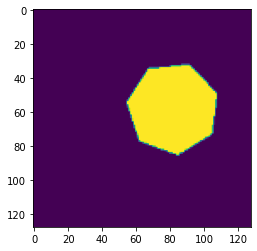

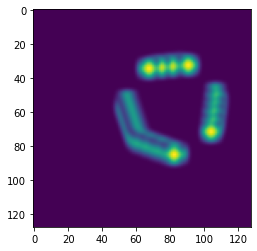

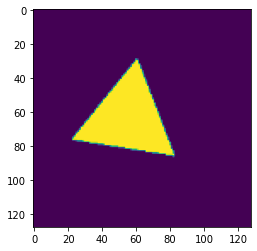

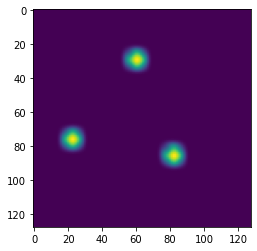

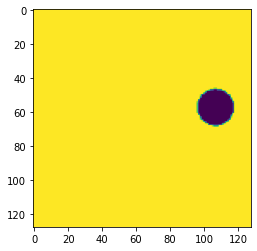

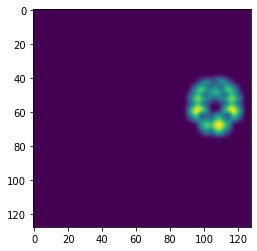

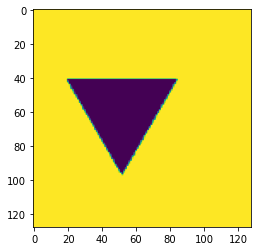

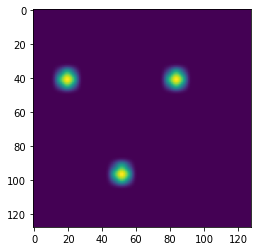

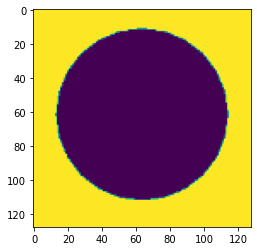

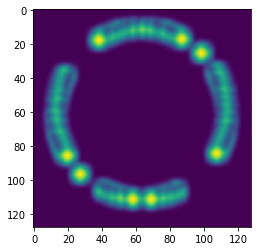

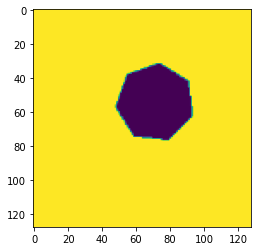

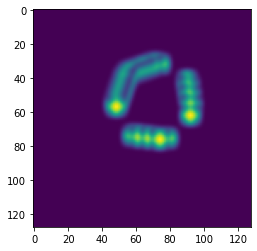

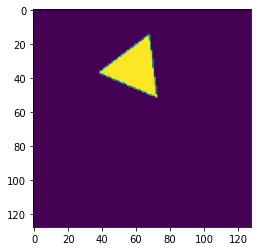

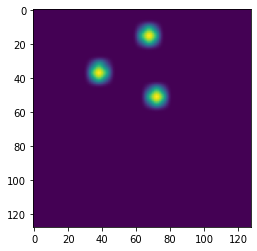

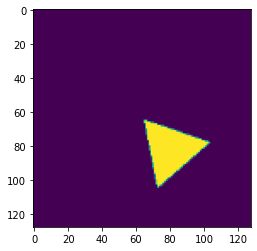

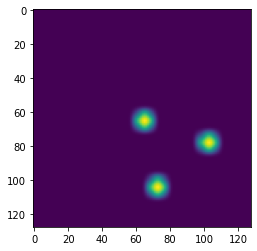

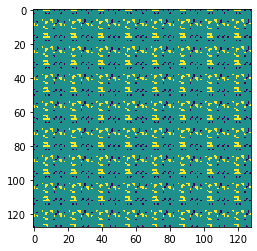

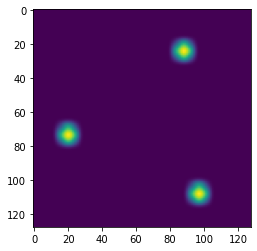

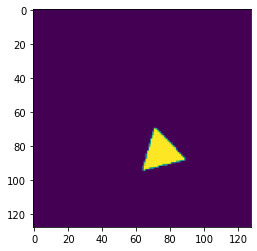

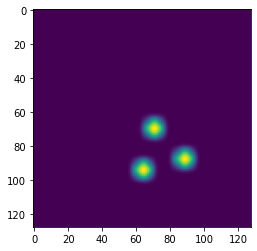

In [12]:
training_data = CustomImageDataset(
    annotations_file= "label.csv",
    transform=transforms.Compose([transforms.Resize((128,128))]),
    target_transform=transforms.Compose([transforms.Resize((128,128))])
)
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
train_features, train_labels = next(iter(train_dataloader))
train_labels.shape

test_data = CustomImageDataset(
    annotations_file= 'test.csv',
    transform=transforms.Compose([transforms.Resize((128,128))]),
    target_transform=transforms.Compose([transforms.Resize((128,128))])
)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)
test_features, test_labels = next(iter(test_dataloader))
for i in range(10):
    plt.figure()
    plt.imshow(test_features[i][0].numpy())
    plt.figure()
    plt.imshow(test_labels[i][0].numpy())

In [13]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'
#device = 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [14]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=1, stride=1, padding=0)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=1, stride=1, padding=0)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=1, stride=1, padding=0)
        self.conv4 = nn.Conv2d(32, 64, kernel_size=1, stride=1, padding=0)
        self.convT1 = nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0)
        self.convT2 = nn.Conv2d(32, 16, kernel_size=1, stride=1, padding=0)
        self.convT3 = nn.Conv2d(16, 8, kernel_size=1, stride=1, padding=0)
        self.convT4 = nn.Conv2d(8, 1, kernel_size=1, stride=1, padding=0)
        self.relu = nn.LeakyReLU()
        self.mp = nn.MaxPool2d(2, 2)
        self.mup = nn.MaxUnpool2d(2,2)
        self.sigmoid = nn.Sigmoid()
        self.batchnorm1 = nn.BatchNorm2d(8)
        self.batchnorm2 = nn.BatchNorm2d(16)
        self.batchnorm3 = nn.BatchNorm2d(32)
        self.batchnorm4 = nn.BatchNorm2d(64)
        
        self.encoder1 = nn.Sequential(
            nn.Conv2d(8,8,kernel_size = 3,stride=1,padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(8,8,kernel_size = 3,stride=1,padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(8,8,kernel_size = 3,stride=1,padding=1),
        )
        self.encoder2 = nn.Sequential(
            nn.Conv2d(16,16,kernel_size = 3,stride=1,padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(16,16,kernel_size = 3,stride=1,padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(16,16,kernel_size = 3,stride=1,padding=1),
        )
        self.encoder3 = nn.Sequential(
            nn.Conv2d(32,32,kernel_size = 3,stride=1,padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(32,32,kernel_size = 3,stride=1,padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(32,32,kernel_size = 3,stride=1,padding=1),
        )
        self.encoder4 = nn.Sequential(
            nn.Conv2d(64,64,kernel_size = 3,stride=1,padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(64,64,kernel_size = 3,stride=1,padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(64,64,kernel_size = 3,stride=1,padding=1),
        )
        self.decoder1=nn.Sequential(
            nn.ConvTranspose2d(64,64,kernel_size = 3,stride=1,padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64,64,kernel_size = 3,stride=1,padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64,64,kernel_size = 3,stride=1,padding=1),
        )
        self.decoder2=nn.Sequential(
            nn.ConvTranspose2d(32,32,kernel_size = 3,stride=1,padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(32,32,kernel_size = 3,stride=1,padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(32,32,kernel_size = 3,stride=1,padding=1),
        )
        self.decoder3=nn.Sequential(
            nn.ConvTranspose2d(16,16,kernel_size = 3,stride=1,padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(16,16,kernel_size = 3,stride=1,padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(16,16,kernel_size = 3,stride=1,padding=1),
        )
        self.decoder4=nn.Sequential(
            nn.ConvTranspose2d(8,8,kernel_size = 3,stride=1,padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(8,8,kernel_size = 3,stride=1,padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(8,8,kernel_size = 3,stride=1,padding=1),
        )
    def forward(self, features):
        x = self.encode(features.float())
        x = self.decode(x)
        return x
    
    def encode(self, features):
        x = self.conv1(features.float()) #3 to 8
        residual = x
        x = self.encoder1(x)
        x = 0.5*(x + residual)
        x = self.relu(x)
        x = self.mp(x)
        x = self.batchnorm1(x)

        x = self.conv2(x) #8 to 16
        residual = x
        x = self.encoder2(x)
        x = 0.5*(x + residual)
        x = self.relu(x)
        x = self.batchnorm2(x)
        
        residual = x #16 to 16
        x = self.encoder2(x)
        x = 0.5*(x + residual)
        x = self.relu(x)
        x = self.batchnorm2(x)
        
        residual = x #16 to 16
        x = self.encoder2(x)
        x = 0.5*(x + residual)
        x = self.relu(x)
        x = self.mp(x)
        x = self.batchnorm2(x)
        
        x = self.conv3(x) #16 to 32
        residual = x
        x = self.encoder3(x)
        x = 0.5*(x + residual)
        x = self.relu(x)
        x = self.batchnorm3(x)
        
        residual = x #32 to 32
        x = self.encoder3(x)
        x = 0.5*(x + residual)
        x = self.relu(x)
        x = self.batchnorm3(x)
        
        residual = x #32 to 32
        x = self.encoder3(x)
        x = 0.5*(x + residual)
        x = self.relu(x)
        x = self.mp(x)
        x = self.batchnorm3(x)
        
        x = self.conv4(x) #32 to 64
        residual = x
        x = self.encoder4(x)
        x = 0.5*(x + residual)
        x = self.relu(x)
        x = self.batchnorm4(x)
        
        residual = x #64 to 64
        x = self.encoder4(x)
        x = 0.5*(x + residual)
        x = self.relu(x)
        x = self.batchnorm4(x)
        
        residual = x #64 to 64
        x = self.encoder4(x)
        x = 0.5*(x + residual)
        x = self.relu(x)
        x = self.batchnorm4(x)
        
        return x

    def decode(self, features):
        #x = interpolate(features.float(), scale_factor=2)
        residual = features.float() #64 to 64
        x = self.decoder1(features.float())
        x = 0.5*(x + residual)
        x = self.relu(x)
        x = self.batchnorm4(x)
        
        residual = x #64 to 64
        x = self.decoder1(x)
        x = 0.5*(x + residual)
        x = self.relu(x)
        x = self.batchnorm4(x)
         
        x = self.convT1(x) #64 to 32
        x = interpolate(x, scale_factor=2)
        residual = x
        x = self.decoder2(x)
        x = 0.5*(x + residual)
        x = self.relu(x)
        x = self.batchnorm3(x)
        
        residual = x #32 to 32
        x = self.decoder2(x)
        x = 0.5*(x + residual)
        x = self.relu(x)
        x = self.batchnorm3(x)
        
        residual = x #32 to 32
        x = self.decoder2(x)
        x = 0.5*(x + residual)
        x = self.relu(x)
        x = self.batchnorm3(x)
        
        x = self.convT2(x) #32 to 16
        x = interpolate(x, scale_factor=2)
        residual = x 
        x = self.decoder3(x)
        x = 0.5*(x + residual)
        x = self.relu(x)
        x = self.batchnorm2(x)
        
        residual = x #16 to 16
        x = self.decoder3(x)
        x = 0.5*(x + residual)
        x = self.relu(x)
        x = self.batchnorm2(x)
        
        residual = x  #16 to 16
        x = self.decoder3(x)
        x = 0.5*(x + residual)
        x = self.relu(x)
        x = self.batchnorm2(x)
        
        x = self.convT3(x) #16 to 8
        x = interpolate(x, scale_factor=2)
        residual = x 
        x = self.decoder4(x)
        x = 0.5*(x + residual)
        x = self.relu(x)
        x = self.batchnorm1(x)
        
        residual = x #8 to 8
        x = self.decoder4(x)
        x = 0.5*(x + residual)
        x = self.relu(x)
        x = self.batchnorm1(x)
        
        residual = x #8 to 8
        x = self.decoder4(x)
        x = 0.5*(x + residual)
        x = self.relu(x)
        x = self.batchnorm1(x)
        
        x = self.convT4(x) #8 to 1
        x = self.sigmoid(x)
        return x
    
model = CNN().to(device)

In [15]:
"""
dummy = torch.ones(64,3,128,128).to(device)
a = model(dummy)
a.shape
"""

'\ndummy = torch.ones(64,3,128,128).to(device)\na = model(dummy)\na.shape\n'

In [16]:
lr = 0.001
m = 0.9
opt = optim.SGD(model.parameters(), lr=lr, momentum=m)
#loss_fn = nn.MSELoss()
loss_fn = nn.BCELoss()
def loss_function(output, target):
    #print(output.max())
    #print(output.min())
    
    #exp_output = exp_output/torch.sum(exp_output)
    
    #print(exp_output.max())
    #print(exp_output.min())
    #plt.figure()
    #plt.imshow(exp_output[0].cpu().detach().numpy().reshape(96,96,1))
    #plt.colorbar()
    #plt.show()
    loss = (torch.sum(torch.sum((output*output - target*target)**2)))**(1/2) #+ (torch.mean(torch.sum((output*(1-target) - (1-target)*(1-target))**2)))**(1/2)
    return loss


wandb: Currently logged in as: sushlokshah (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


loss: 287.468079  [    0/90000]


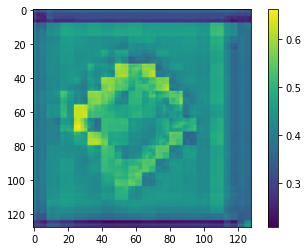

loss: 170.682699  [  128/90000]
loss: 127.375396  [  256/90000]
loss: 112.560434  [  384/90000]
loss: 103.498927  [  512/90000]
loss: 100.019780  [  640/90000]
loss: 95.663380  [  768/90000]
loss: 93.466443  [  896/90000]
loss: 95.615856  [ 1024/90000]


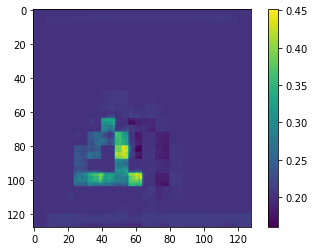

loss: 98.005386  [ 1152/90000]
loss: 92.736213  [ 1280/90000]
loss: 92.163028  [ 1408/90000]
loss: 94.177101  [ 1536/90000]
loss: 92.365249  [ 1664/90000]
loss: 97.953007  [ 1792/90000]
loss: 90.755072  [ 1920/90000]
loss: 93.050441  [ 2048/90000]


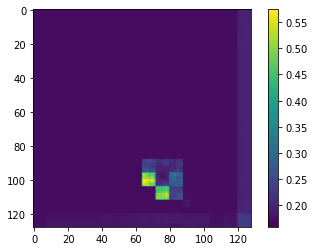

loss: 93.282000  [ 2176/90000]
loss: 90.944449  [ 2304/90000]
loss: 88.036921  [ 2432/90000]
loss: 88.946821  [ 2560/90000]
loss: 87.621458  [ 2688/90000]
loss: 85.643767  [ 2816/90000]
loss: 92.151047  [ 2944/90000]
loss: 93.368632  [ 3072/90000]


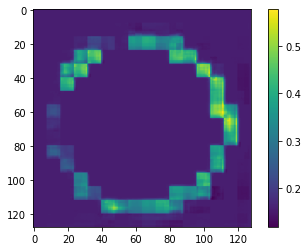

loss: 89.144881  [ 3200/90000]
loss: 90.407202  [ 3328/90000]
loss: 88.253310  [ 3456/90000]
loss: 90.673529  [ 3584/90000]
loss: 85.803757  [ 3712/90000]
loss: 93.071748  [ 3840/90000]
loss: 88.047286  [ 3968/90000]
loss: 91.092938  [ 4096/90000]


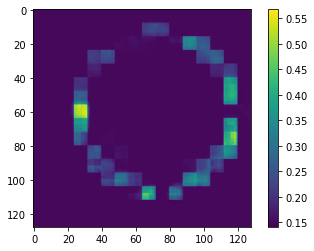

loss: 88.884916  [ 4224/90000]
loss: 89.209245  [ 4352/90000]
loss: 87.247669  [ 4480/90000]
loss: 87.519959  [ 4608/90000]
loss: 85.020105  [ 4736/90000]
loss: 85.311327  [ 4864/90000]


In [ ]:
import wandb

config = dict (
    learning_rate =lr,
    momentum = m,
    batchsize = 128,
    architecture = "similar to resnet",
    dataset_id = "shape dataset",
)

wandb.init(
    project="feature detection on different shapes",
    config=config,
)

for epoch in range(4):
    for batch, (xb, yb) in enumerate(train_dataloader):
        #print(len(xb))
        X, y = xb.to(device), yb.to(device)
        #print(X.shape)
        # Compute prediction error
        pred = model(X)
        #print(pred.shape,y.shape)
        loss = loss_function(pred,y)
        loss.backward()
        with torch.no_grad():
            for p in model.parameters():
                p -= p.grad * lr
            model.zero_grad()
        wandb.log({"train_loss": loss.item(), "epoch": 4,"lr" : lr,})
        if batch % 2 == 0:
            loss, current = loss.item(), (batch)*len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{90000:>5d}]")
        if batch % 16 == 0:
            plt.figure()
            plt.imshow(pred[0].cpu().detach().numpy().reshape(128,128,1))
            plt.colorbar()
            plt.show()

In [ ]:
for i in range(27):
    plt.figure()
    plt.imshow(pred[i].cpu().detach().numpy().reshape(128,128,1))

torch.save(model, 'features.pth')

In [ ]:
torch.save(model, 'features.pth')